In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set()

In [2]:
df = pd.read_csv('../dataset/GOOG-year.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-04,1308.229980,1327.660034,1299.000000,1326.800049,1326.800049,1504000
1,2020-05-05,1337.920044,1373.939941,1337.459961,1351.109985,1351.109985,1651500
2,2020-05-06,1361.689941,1371.119995,1347.290039,1347.300049,1347.300049,1215400
3,2020-05-07,1365.939941,1377.599976,1355.270020,1372.560059,1372.560059,1397600
4,2020-05-08,1383.130005,1398.760010,1375.479980,1388.369995,1388.369995,1386900


In [3]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        return decision

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [4]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, window_size, trend, skip, initial_money):
        self.model = model
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision = self.model.predict(np.array(sequence))
        return np.argmax(decision[0])
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = self.get_state(0)
        inventory = []
        quantity = 0
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                starting_money -= close[t]
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                starting_money += self.trend[t]

            state = next_state
        return ((starting_money - initial_money) / initial_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = self.get_state(0)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

In [5]:
close = df.Close.values.tolist()
window_size = 30
skip = 1
initial_money = 10000

model = Model(input_size = window_size, layer_size = 500, output_size = 3)
agent = Agent(model = model, 
              window_size = window_size,
              trend = close,
              skip = skip,
              initial_money = initial_money)
agent.fit(iterations = 500, checkpoint = 10)

iter 10. reward: 41.058799
iter 20. reward: 40.113655
iter 30. reward: 66.639198
iter 40. reward: 69.350748
iter 50. reward: 68.429850
iter 60. reward: 72.015697
iter 70. reward: 74.575449
iter 80. reward: 75.066849
iter 90. reward: 81.574751
iter 100. reward: 85.637747
iter 110. reward: 84.307648
iter 120. reward: 83.104850
iter 130. reward: 82.898898
iter 140. reward: 83.887948
iter 150. reward: 84.920249
iter 160. reward: 84.872647
iter 170. reward: 85.025450
iter 180. reward: 81.098555
iter 190. reward: 84.458251
iter 200. reward: 87.698551
iter 210. reward: 86.102750
iter 220. reward: 89.542250
iter 230. reward: 87.817848
iter 240. reward: 88.299552
iter 250. reward: 87.168251
iter 260. reward: 87.678453
iter 270. reward: 87.264653
iter 280. reward: 90.029351
iter 290. reward: 85.082853
iter 300. reward: 86.606353
iter 310. reward: 84.548750
iter 320. reward: 91.348147
iter 330. reward: 90.985200
iter 340. reward: 89.999050
iter 350. reward: 90.511449
iter 360. reward: 92.075651
i

In [6]:
states_buy, states_sell, total_gains, invest = agent.buy()

day 4: buy 1 unit at price 1388.369995, total balance 8611.630005
day 5, sell 1 unit at price 1403.260010, investment 1.072482 %, total balance 10014.890015,
day 7: buy 1 unit at price 1349.329956, total balance 8665.560059
day 8: buy 1 unit at price 1356.130005, total balance 7309.430054
day 11: buy 1 unit at price 1373.484985, total balance 5935.945069
day 12, sell 1 unit at price 1406.719971, investment 4.253223 %, total balance 7342.665040,
day 13, sell 1 unit at price 1402.800049, investment 3.441414 %, total balance 8745.465089,
day 14, sell 1 unit at price 1410.420044, investment 2.689149 %, total balance 10155.885133,
day 15: buy 1 unit at price 1417.020020, total balance 8738.865113
day 18: buy 1 unit at price 1428.920044, total balance 7309.945069
day 19: buy 1 unit at price 1431.819946, total balance 5878.125123
day 20, sell 1 unit at price 1439.219971, investment 1.566665 %, total balance 7317.345094,
day 21: buy 1 unit at price 1436.380005, total balance 5880.965089
day 22

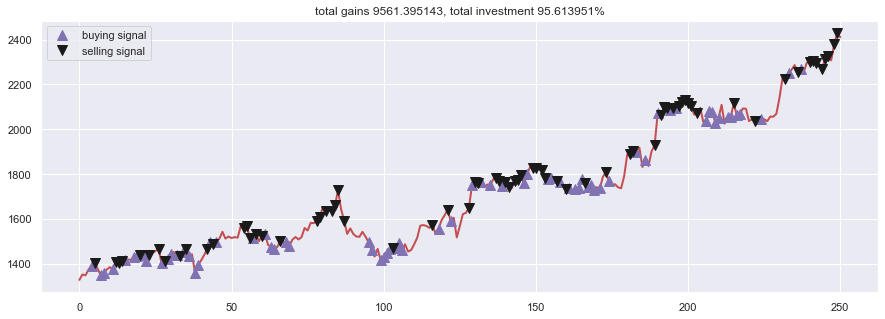

In [7]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()